In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import analyze_cells_energy as ace
import re
import utils
import itertools
import seaborn as sns
import utils_PLS as upls

In [2]:
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database(volumes)

In [3]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'SWISS_MaleUrine_Exposure'
batch='SWISS_19-35'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
dict_results_across_mice = np.load('dict_results/dict_results_across_mice_SW19-35-200_7-7.npy', allow_pickle=True).item()

In [4]:
# removed key corresponding to SW21_Fam
dict_results_across_mice.pop('SW21_Fam')

,area,n_cells,energy
0,Frontal pole cerebral cortex,112,151002.907754
1,Primary motor area,185,30601.699705
2,Secondary motor area,465,58061.559705
3,Primary somatosensory area,290,23865.770545
4,Supplemental somatosensory area,73,19470.154174
...,...,...,...
194,Interfascicular nucleus raphe,41,434565.841256
195,Interpeduncular nucleus,44,134099.352738
196,Rostral linear nucleus raphe,7,103817.475604
197,Central linear nucleus raphe,1,9811.633176


In [5]:
dict_results_across_mice = upls.reformat_dict_acronym(dict_results=dict_results_across_mice, volumes=volumes)

# Format data for task PLS

In [25]:
upls.format_data_pls(dict_results=dict_results_across_mice, batch=batch+'-200_7-7', table='n_cells')
upls.format_data_pls(dict_results=dict_results_across_mice, batch=batch+'-200_7-7', table='energy')

In [28]:
data_ncells = pd.read_csv('./results_pls/'+batch+'-200_7-7_n_cells.csv')
data_energy = pd.read_csv('./results_pls/'+batch+'-200_7-7_energy.csv')

In [29]:
df_levels = upls.create_df_levels(volumes)

# Apply task PLS for all areas and energy

In [30]:
%%bash
python area_pls.py -i results_pls/SWISS_19-35-200_7-7_n_cells.csv -o './results_pls/SWISS_19-35-200_7-7'

2023-05-26 15:43:49 PC1QFRRQ __main__[113712] INFO reading data...
2023-05-26 15:43:49 PC1QFRRQ __main__[113712] INFO computing PLS...
2023-05-26 15:43:49 PC1QFRRQ __main__[113712] INFO PLS computed, now performing bootstrap...
2023-05-26 15:43:49 PC1QFRRQ __main__[113712] INFO saving output data...


In [10]:
# %%bash
# python area_pls.py -i results_pls/SWISS_19-35_energy.csv -o './'

# Plot results

In [31]:
swiss_contrasts = pd.read_csv('./results_pls/SWISS_19-35-200_10-10_contrasts.csv')
swiss_saliences = pd.read_csv('./results_pls/SWISS_19-35-200_10-10_saliences.csv')
swiss_contrasts.columns = ['Control', 'Fam', 'Unfam']
# swiss_contrasts = swiss_contrasts.rename(columns={"group_Control": "Control", "group_Fam": "Fam", "group_Unfam":"Unfam"})

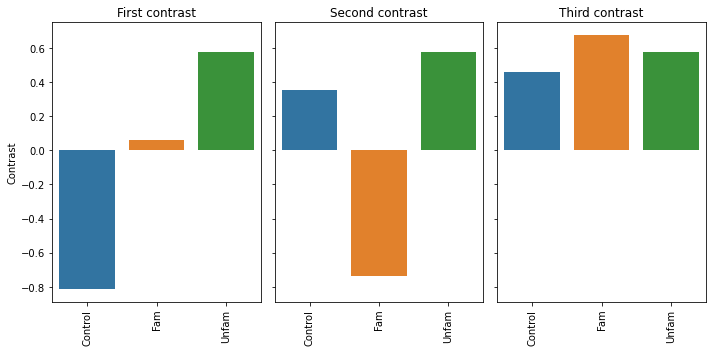

In [32]:
fig, axes = plt.subplots(1,3, sharey='row', figsize=(10,5))
upls.plot_contrasts(df_data=swiss_contrasts, index=0, ax=axes[0])
upls.plot_contrasts(df_data=swiss_contrasts, index=1, ax=axes[1])
upls.plot_contrasts(df_data=swiss_contrasts, index=2, ax=axes[2])
axes[0].set_ylabel('Contrast')
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[2].tick_params(axis='x', labelrotation=90)
axes[0].set_title('First contrast')
axes[1].set_title('Second contrast')
axes[2].set_title('Third contrast')
for i in range(3):
    axes[i].set(xlabel=None)
plt.tight_layout()
plt.savefig('./results_pls/swiss_19-35-200_10-10_pls_contrasts_all_areas.png')
plt.savefig('./results_pls/swiss_19-35-200_10-10_pls_contrasts_all_areas.png')

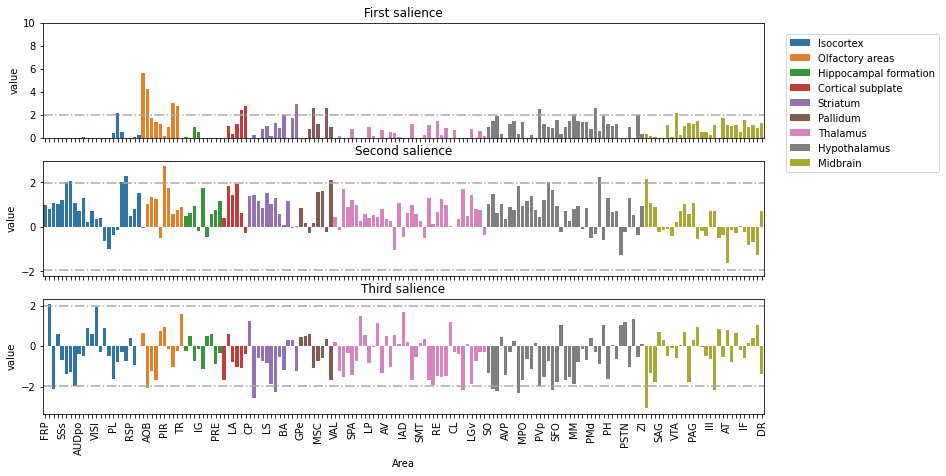

In [33]:
fig, axes = plt.subplots(3,1, sharex='row', figsize=(13,7))
plt.subplots_adjust(top=0.9, left=0.03, right=0.8)
upls.plot_saliences(df_data=swiss_saliences, index=0, ax=axes[0], df_levels=df_levels)
upls.plot_saliences(df_data=swiss_saliences, index=1, ax=axes[1], df_levels=df_levels)
upls.plot_saliences(df_data=swiss_saliences, index=2, ax=axes[2], df_levels=df_levels)
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[2].tick_params(axis='x', labelrotation=90)
axes[0].set_xlabel('')
axes[0].set(xticklabels=[])
axes[0].set_ylim(0,10)
axes[1].set_xlabel('')
axes[1].set(xticklabels=[])
axes[0].set_title('First salience')
axes[1].set_title('Second salience')
axes[2].set_title('Third salience')
axes[2].set_xlabel('Area')
axes[0].legend(loc='right', bbox_to_anchor=(1.25,0.3))
axes[1].get_legend().remove()
axes[2].get_legend().remove()
n = 4  # Keeps every 7th label
for i in range(3):
    axes[i].axhline(y=1.96, linestyle='-.', color='darkgrey')
    axes[i].axhline(y=-1.96, linestyle='-.', color='darkgrey')
    [l.set_visible(False) for (i,l) in enumerate(axes[i].xaxis.get_ticklabels()) if i % n != 0]
plt.savefig('./results_pls/swiss_19-35-200_10-10_pls_saliences_all_areas.png')
plt.savefig('./results_pls/swiss_19-35-200_10-10_pls_saliences_all_areas.svg')

# Identify areas with significant salience contribution

In [34]:
pls_sig_areas = upls.identify_pls_sig_areas(saliences=swiss_saliences, 
                                       threshold=1.96, 
                                       volumes=volumes)

In [35]:
pls_sig_areas

array(['Accessory olfactory bulb', 'Agranular insular area',
       'Arcuate hypothalamic nucleus', 'Basomedial amygdalar nucleus',
       'Bed nuclei of the stria terminalis',
       'Bed nucleus of the anterior commissure',
       'Cortical amygdalar area', 'Dorsal auditory area',
       'Edinger-Westphal nucleus', 'Infralimbic area',
       'Magnocellular nucleus', 'Main olfactory bulb',
       'Medial amygdalar nucleus', 'Medial mammillary nucleus',
       'Median preoptic nucleus', 'Nucleus accumbens', 'Orbital area',
       'Paraventricular hypothalamic nucleus',
       'Paraventricular hypothalamic nucleus descending division',
       'Periventricular hypothalamic nucleus posterior part',
       'Piriform area', 'Piriform-amygdalar area',
       'Posterior amygdalar nucleus', 'Primary auditory area',
       'Primary motor area', 'Reticular nucleus of the thalamus',
       'Secondary motor area', 'Septohippocampal nucleus',
       'Subparaventricular zone', 'Superior colliculus s

# Apply PLS for all significant areas in ncells and energy

In [36]:
# select significant areas
experimental_groups = utils.divide_in_exp_groups(list_subjects=list(dict_results_across_mice.keys()))
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')
df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
sig_areas_ncells_ttest = upls.select_significant_areas(df=df_ttest_not_null_ncells, threshold=0.05)
# get corresponding acronyms of these areas
sig_acronyms = [volumes.loc[volumes['safe_name'] == area]['acronym'].values[0] for area in sig_areas_ncells_ttest]
# remove columns from database
keep_columns = ['subject', 'sex', 'group'] + sig_acronyms
# make database filtered
data_ncells_filt = data_ncells.drop(columns=[col for col in data_ncells if col not in keep_columns])
data_energy_filt = data_energy.drop(columns=[col for col in data_energy if col not in keep_columns])
data_ncells_filt.to_csv('./results_pls/'+batch+'-200_10-10_n_cells_filt.csv')
data_energy_filt.to_csv('./results_pls/'+batch+'-200_10-10_energy_filt.csv')

In [43]:
%%bash
python area_pls.py -i results_pls/SWISS_19-35-200_10-10_n_cells_filt.csv -o './results_pls/SWISS_19-35-200_10-10_filt_ncells'

2023-05-26 15:59:17 PC1QFRRQ __main__[114357] INFO reading data...
2023-05-26 15:59:17 PC1QFRRQ __main__[114357] INFO computing PLS...
2023-05-26 15:59:17 PC1QFRRQ __main__[114357] INFO PLS computed, now performing bootstrap...
2023-05-26 15:59:17 PC1QFRRQ __main__[114357] INFO saving output data...


In [54]:
%%bash
python area_pls.py -i results_pls/SWISS_19-35-200_10-10_energy_filt.csv -o './results_pls/SWISS_19-35_200_10-10_filt_energy'

2023-05-26 16:23:49 PC1QFRRQ __main__[117411] INFO reading data...
2023-05-26 16:23:49 PC1QFRRQ __main__[117411] INFO computing PLS...
2023-05-26 16:23:49 PC1QFRRQ __main__[117411] INFO PLS computed, now performing bootstrap...
2023-05-26 16:23:49 PC1QFRRQ __main__[117411] INFO saving output data...


# PLS on number of cells

In [45]:
swiss_contrasts_filt = pd.read_csv('./results_pls/SWISS_19-35-200_10-10_filt_ncells_contrasts.csv')
swiss_saliences_filt = pd.read_csv('./results_pls/SWISS_19-35-200_10-10_filt_ncells_saliences.csv')
swiss_contrasts_filt.columns = ['Control', 'Fam', 'Unfam']

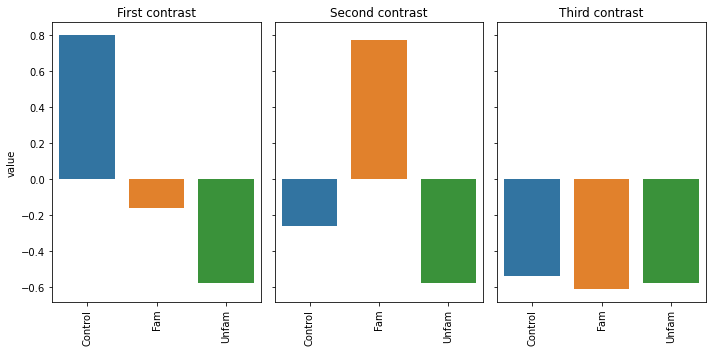

In [46]:
fig, axes = plt.subplots(1,3, sharey='row', figsize=(10,5))
upls.plot_contrasts(df_data=swiss_contrasts_filt, index=0, ax=axes[0])
upls.plot_contrasts(df_data=swiss_contrasts_filt, index=1, ax=axes[1])
upls.plot_contrasts(df_data=swiss_contrasts_filt, index=2, ax=axes[2])
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[2].tick_params(axis='x', labelrotation=90)
axes[0].set_title('First contrast')
axes[1].set_title('Second contrast')
axes[2].set_title('Third contrast')
for i in range(3):
    axes[i].set(xlabel=None)
plt.tight_layout()
plt.savefig('./results_pls/swiss_19-35-200_10-10_pls_contrasts_sig_areas_ncells.png')

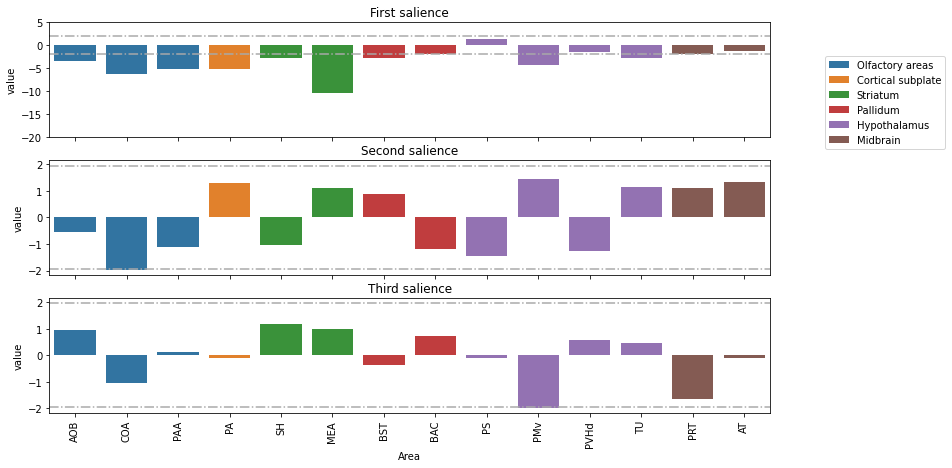

In [47]:
fig, axes = plt.subplots(3,1, sharex='row', figsize=(13,7))
plt.subplots_adjust(top=0.9, left=0.03, right=0.8)
upls.plot_saliences(df_data=swiss_saliences_filt, index=0, ax=axes[0], df_levels=df_levels)
upls.plot_saliences(df_data=swiss_saliences_filt, index=1, ax=axes[1], df_levels=df_levels)
upls.plot_saliences(df_data=swiss_saliences_filt, index=2, ax=axes[2], df_levels=df_levels)
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[2].tick_params(axis='x', labelrotation=90)
axes[0].set_xlabel('')
axes[0].set(xticklabels=[])
axes[0].set_ylim(-20,5)
axes[1].set_xlabel('')
axes[1].set(xticklabels=[])
axes[0].set_title('First salience')
axes[1].set_title('Second salience')
axes[2].set_title('Third salience')
axes[2].set_xlabel('Area')
axes[0].legend(loc='right', bbox_to_anchor=(1.25,0.3))
axes[1].get_legend().remove()
axes[2].get_legend().remove()
n = 4  # Keeps every 7th label
for i in range(3):
    axes[i].axhline(y=1.96, linestyle='-.', color='darkgrey')
    axes[i].axhline(y=-1.96, linestyle='-.', color='darkgrey')
plt.savefig('./results_pls/swiss_pls_200_10-10_saliences_sig_areas_ncells.png')
plt.savefig('./results_pls/swiss_pls_200_10-10_saliences_sig_areas_ncells.svg')

# PLS on energy

In [56]:
swiss_contrasts_filt = pd.read_csv('./results_pls/SWISS_19-35_200_10-10_filt_energy_contrasts.csv')
swiss_saliences_filt = pd.read_csv('./results_pls/SWISS_19-35_200_10-10_filt_energy_saliences.csv')
swiss_contrasts_filt.columns = ['Control', 'Fam', 'Unfam']

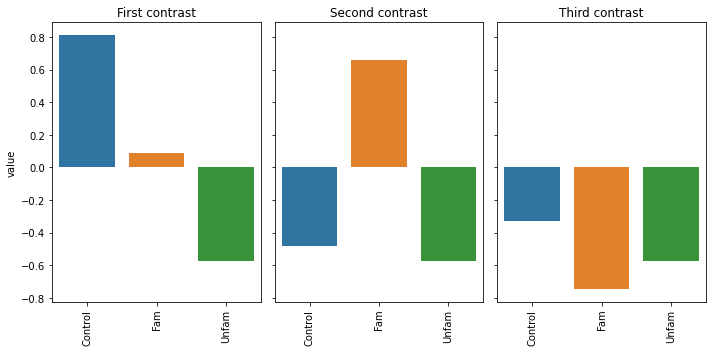

In [57]:
fig, axes = plt.subplots(1,3, sharey='row', figsize=(10,5))
upls.plot_contrasts(df_data=swiss_contrasts_filt, index=0, ax=axes[0])
upls.plot_contrasts(df_data=swiss_contrasts_filt, index=1, ax=axes[1])
upls.plot_contrasts(df_data=swiss_contrasts_filt, index=2, ax=axes[2])
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[2].tick_params(axis='x', labelrotation=90)
axes[0].set_title('First contrast')
axes[1].set_title('Second contrast')
axes[2].set_title('Third contrast')
for i in range(3):
    axes[i].set(xlabel=None)
plt.tight_layout()
plt.savefig('./results_pls/swiss_19-35-200_10-10_pls_contrasts_sig_areas_energy.png')

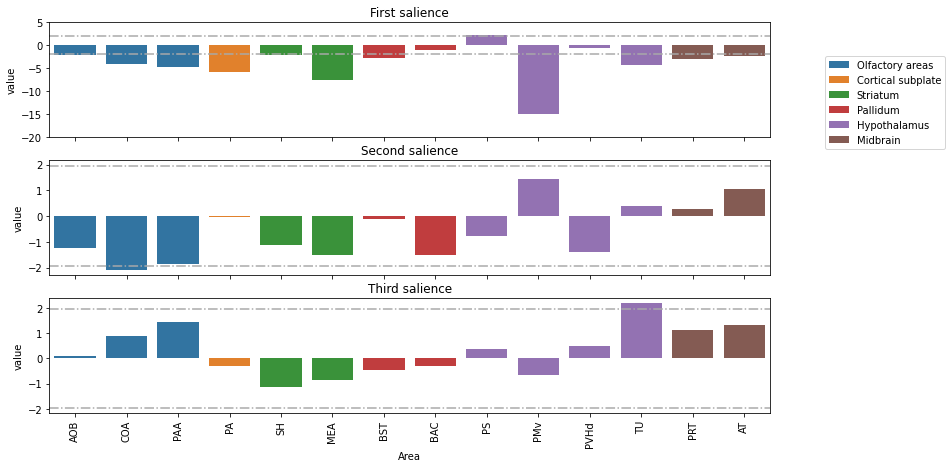

In [58]:
fig, axes = plt.subplots(3,1, sharex='row', figsize=(13,7))
plt.subplots_adjust(top=0.9, left=0.03, right=0.8)
upls.plot_saliences(df_data=swiss_saliences_filt, index=0, ax=axes[0], df_levels=df_levels)
upls.plot_saliences(df_data=swiss_saliences_filt, index=1, ax=axes[1], df_levels=df_levels)
upls.plot_saliences(df_data=swiss_saliences_filt, index=2, ax=axes[2], df_levels=df_levels)
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[2].tick_params(axis='x', labelrotation=90)
axes[0].set_xlabel('')
axes[0].set(xticklabels=[])
axes[0].set_ylim(-20,5)
axes[1].set_xlabel('')
axes[1].set(xticklabels=[])
axes[0].set_title('First salience')
axes[1].set_title('Second salience')
axes[2].set_title('Third salience')
axes[2].set_xlabel('Area')
axes[0].legend(loc='right', bbox_to_anchor=(1.25,0.3))
axes[1].get_legend().remove()
axes[2].get_legend().remove()
n = 4  # Keeps every 7th label
for i in range(3):
    axes[i].axhline(y=1.96, linestyle='-.', color='darkgrey')
    axes[i].axhline(y=-1.96, linestyle='-.', color='darkgrey')
plt.savefig('./results_pls/swiss_pls_200_10-10_saliences_sig_areas_energy.png')
plt.savefig('./results_pls/swiss_pls_200_10-10_saliences_sig_areas_energy.svg')

# Identify areas with significant salience contribution

In [42]:
pls_sig_areas_filt = upls.identify_pls_sig_areas(saliences=swiss_saliences_filt, 
                                       threshold=1.96, 
                                       volumes=volumes)
pls_sig_areas_filt

array(['Accessory olfactory bulb', 'Bed nuclei of the stria terminalis',
       'Cortical amygdalar area', 'Medial amygdalar nucleus',
       'Piriform-amygdalar area', 'Posterior amygdalar nucleus',
       'Pretectal region', 'Septohippocampal nucleus', 'Tuberal nucleus',
       'Ventral premammillary nucleus'], dtype='<U34')